**Quora duplicates detection**

`Deadline: 22.03.2022 23:59 msk`

In this homework you will learn how to build an LSTM-based siamese homework and search for the duplicates in quora question pairs dataset.

The homework is based on DeepLearning.AI materials.

# [3 points] **Part 1: Loading the dataset & Looking at it**

For this task a well-known quora duplicate detection dataset will be used. We put the data to the "sample_data" folder in the current runtime (not the best option) but you are free to mount a google drive.

In [1]:
import os
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
PATH_TO_DATA = './'

In [3]:
data = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'))

As you can see the data consists of questions, and the indicator whether they are duplicate (1) or not (0). 

In [4]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
data = data[~data['question1'].isna()]
data = data[~data['question2'].isna()]

In [6]:
# non-duplicate example
questions = data[data['is_duplicate'] == 0].loc[0]
print(f'Q1: {questions.question1}\nQ2: {questions.question2}')

Q1: What is the step by step guide to invest in share market in india?
Q2: What is the step by step guide to invest in share market?


In [7]:
# duplicate example
questions = data[data['is_duplicate'] == 1].loc[7]
print(f'Q1: {questions.question1}\nQ2: {questions.question2}')

Q1: How can I be a good geologist?
Q2: What should I do to be a great geologist?


Now the dataset is going to be divided into train and test parts for our analysis.

In [8]:
train, test = train_test_split(data, stratify=data['is_duplicate'], random_state=42)

**Task:** Do a little exploratory analysis. Find how many duplicates and non-duplicates are there in the train part and any other actions of your interest to better understand the data.

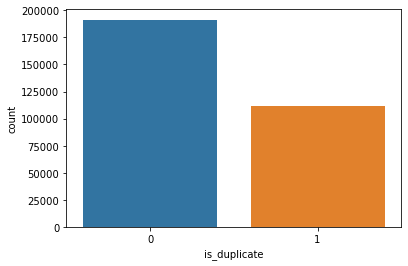

In [9]:
# your code here
sns.countplot(data=train, x='is_duplicate')

Now let's leave only positive examples to train the network. As we remember the negative examples for each of the anchors are taken from the same batch.

In [10]:
train_idx = train[train['is_duplicate'] == 1].id.tolist()
print(f'Number of training examples: {len(train_idx)}')

Number of training examples: 111947


In [11]:
q1_train_data = np.array(train.loc[train_idx, 'question1'])
q2_train_data = np.array(train.loc[train_idx, 'question2'])
q1_test_data = np.array(test['question1'])
q2_test_data = np.array(test['question2'])

q1_train = np.empty_like(q1_train_data)
q2_train = np.empty_like(q2_train_data)
q1_test = np.empty_like(q1_test_data)
q2_test = np.empty_like(q2_test_data)

y_test  = np.array(test['is_duplicate'])

In [12]:
q1_train_data[:5]

array(['Can a Gemini man and a Gemini woman have a successful relationship? Or are they incompatible?',
       'How can I delete my own question from Quora?',
       'Why are there still people who think that the Earth is flat?',
       'What should I do to concentrate more on my studies?',
       'How can one stop caring too much?'], dtype=object)

In [13]:
nltk.download('punkt')

vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in tqdm(range(len(q1_train_data))):
    q1_train[idx] = nltk.word_tokenize(q1_train_data[idx])
    q2_train[idx] = nltk.word_tokenize(q2_train_data[idx])
    q = q1_train[idx] + q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('Vocabulary size is: ', len(vocab))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 111947/111947 [00:46<00:00, 2410.23it/s]

Vocabulary size is:  36413


In [14]:
# processing test

for idx in tqdm(range(len(q1_test_data))): 
    q1_test[idx] = nltk.word_tokenize(q1_test_data[idx])
    q2_test[idx] = nltk.word_tokenize(q2_test_data[idx])

100%|██████████| 101072/101072 [00:44<00:00, 2295.79it/s]


Converting the examples to tensors.

In [15]:
for i in tqdm(range(len(q1_train))):
    q1_train[i] = [vocab[word] for word in q1_train[i]]
    q2_train[i] = [vocab[word] for word in q2_train[i]]

        
for i in tqdm(range(len(q1_test))):
    q1_test[i] = [vocab[word] for word in q1_test[i]]
    q2_test[i] = [vocab[word] for word in q2_test[i]]

100%|██████████| 101072/101072 [00:01<00:00, 92072.35it/s]


To check the model quality we are going to divide the train part into train and validation. 

In [16]:
q1_train, q1_val, q2_train, q2_val = train_test_split(q1_train, q2_train)

In [129]:
class PairsDataset(torch.utils.data.Dataset):
    def __init__(self, q1, q2):
        self.q1 = q1
        self.q2 = q2

    def __getitem__(self, idx):
        item = (self.q1[idx], self.q2[idx])
        return item

    def __len__(self):
        return len(self.q1)

def iterator(q1, q2, batch_size=128, shuffle=False):
    q1, q2 = data_generator(q1, q2, batch_size, shuffle=shuffle) # padding the sequences to the maximum length amongst the samples in batches
    dataset = PairsDataset(q1, q2)
    return dataset

def data_generator(q1, q2, batch_size, pad=1, shuffle=True):
    """Generator function that yields batches of data

    Args:
        q1 (list): List of transformed (to tensor) questions.
        q2 (list): List of transformed (to tensor) questions.
        batch_size (int): Number of elements per batch.
        pad (int, optional): Pad character defaults to 1.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Returns:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [q1a, q2a, q3a, ...] i.e. (q1a,q1b) are duplicates
              input2: targets to your model [q1b, q2b,q3b, ...] i.e. (q1a,q2i) i!=a are not duplicates
    """
    q1_batch_all = []
    q2_batch_all = []
    idx = 0
    len_q = len(q1)
    question_indexes = [*range(len_q)]
    if shuffle:
        random.shuffle(question_indexes)
    ### START CODE HERE (Replace instances of 'None' with your code) ###  
      # get questions at the `question_indexes` position in q1 and q2
    q1 = q1[question_indexes]
    q2 = q2[question_indexes]
    batches_num = ceil(len_q / batch_size)
    q1_batch_all = [q1[(i*batch_size):((i+1)*batch_size)] for i in range(batches_num)]
    q2_batch_all = [q2[(i*batch_size):((i+1)*batch_size)] for i in range(batches_num)]
    for i in range(batches_num):
        ## bug fix solution 1: pick longest sequence between q1 and q2
        # maxlen = max(max([len(ii) for ii in qq1]), max([len(ii) for ii in qq2]))
        max_len = max([len(ii) for ii in q1]) # extracting the maximum length of the seguences
        max_len = 2**int(np.ceil(np.log2(max_len)))
        ## bug fix solution 2: trim long sequence based on current max_len solution
        q1_batch_all[i] = [([pad] * (max_len-len(q_batch))) + q_batch[:max_len] for q_batch in q1_batch_all[i]] # padding the sequences to max_len with pad symbols
        q2_batch_all[i] = [([pad] * (max_len-len(q_batch))) + q_batch[:max_len] for q_batch in q2_batch_all[i]] # padding the sequences to max_len with pad symbols
        q1_batch_all[i] = np.array(q1_batch_all[i])
        q2_batch_all[i] = np.array(q2_batch_all[i])
    return (q1_batch_all, q2_batch_all)

# [7 points] **Part 2: Buiding the siamese network**

In overall siamese network consists of two identical subnetworks with shared weights.

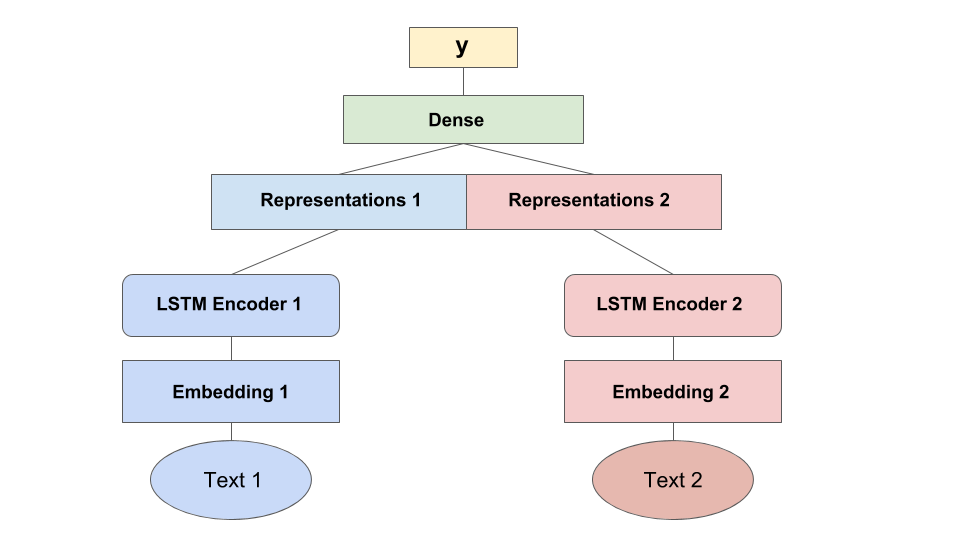

In [18]:
class SiameseModel(nn.Module):
    """ Siamese model.

    Args:
        vocab_size (int, optional): Length of the vocabulary. Defaults to len(vocab).
        d_model (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        A PyTorch Siamese model. 
    """
    def __init__(self, vocab_size=len(vocab), d_model=128, hid_size=256, num_layers=2):
        super(SiameseModel, self).__init__()
        # you are free to modify the network and add additional elements

        self.hidden_dim = hid_size
        self.embed_dim = d_model
        self.n_layers = num_layers

        self.emb =  nn.Embedding(vocab_size, d_model) # defining the embeddings of vocab and d_model size
        self.lstm = nn.LSTM(d_model, hid_size, num_layers, batch_first=True) # Defining an LSTM layer
        self.ll = nn.Linear(hid_size, hid_size) # Using dense layer 

    def forward_once(self, q):
        x = self.emb(q) # make all the transformations with input 
        # print(f'Embedding Output: {x.shape}')
        # print(x)
        x, _ = self.lstm(x)
        # print()
        # print(f'LSTM Output: {x.shape}')
        # print(x)
        x = self.ll(x)
        # print()
        # print(f'Dense Output: {x.shape}')
        # print(x)
        x = torch.mean(x, dim=1) # get the mean accros 1 axis
        # print()
        # print(f'Mean Output: {x.shape}')
        # print(x)
        out = torch.nn.functional.normalize(x) # normalize the output
        # out = x / x.norm(dim=1)[:, None] # normalize the output
        # print()
        # print(f'Normalized Output: {out.shape}')
        # print(out)
        return out

    def forward(self, q1, q2):        
        o1 = self.forward_once(q1)                
        o2 = self.forward_once(q2)
        return (o1, o2)    

In [19]:
# model = SiameseModel()
# print(model)

# [8 points] **Part 3: Measuring the quality**

To calculate loss we will use `Triplet Loss`. 



As we've taken only the pairs of duplicates to our etraining dataset, because all the other embeddings in butch can be considered negative examples. Thus, after calculating the cosine similarity between embeddings we get matrix where diagonal elements correspond to duplicate examples and all non-diagonal - to negative examples. Mining hard-negatives is quite simple in this case - taking the highest value in a row, without the diagonal element. The final loss uses information on mean negative and hard negative scres.

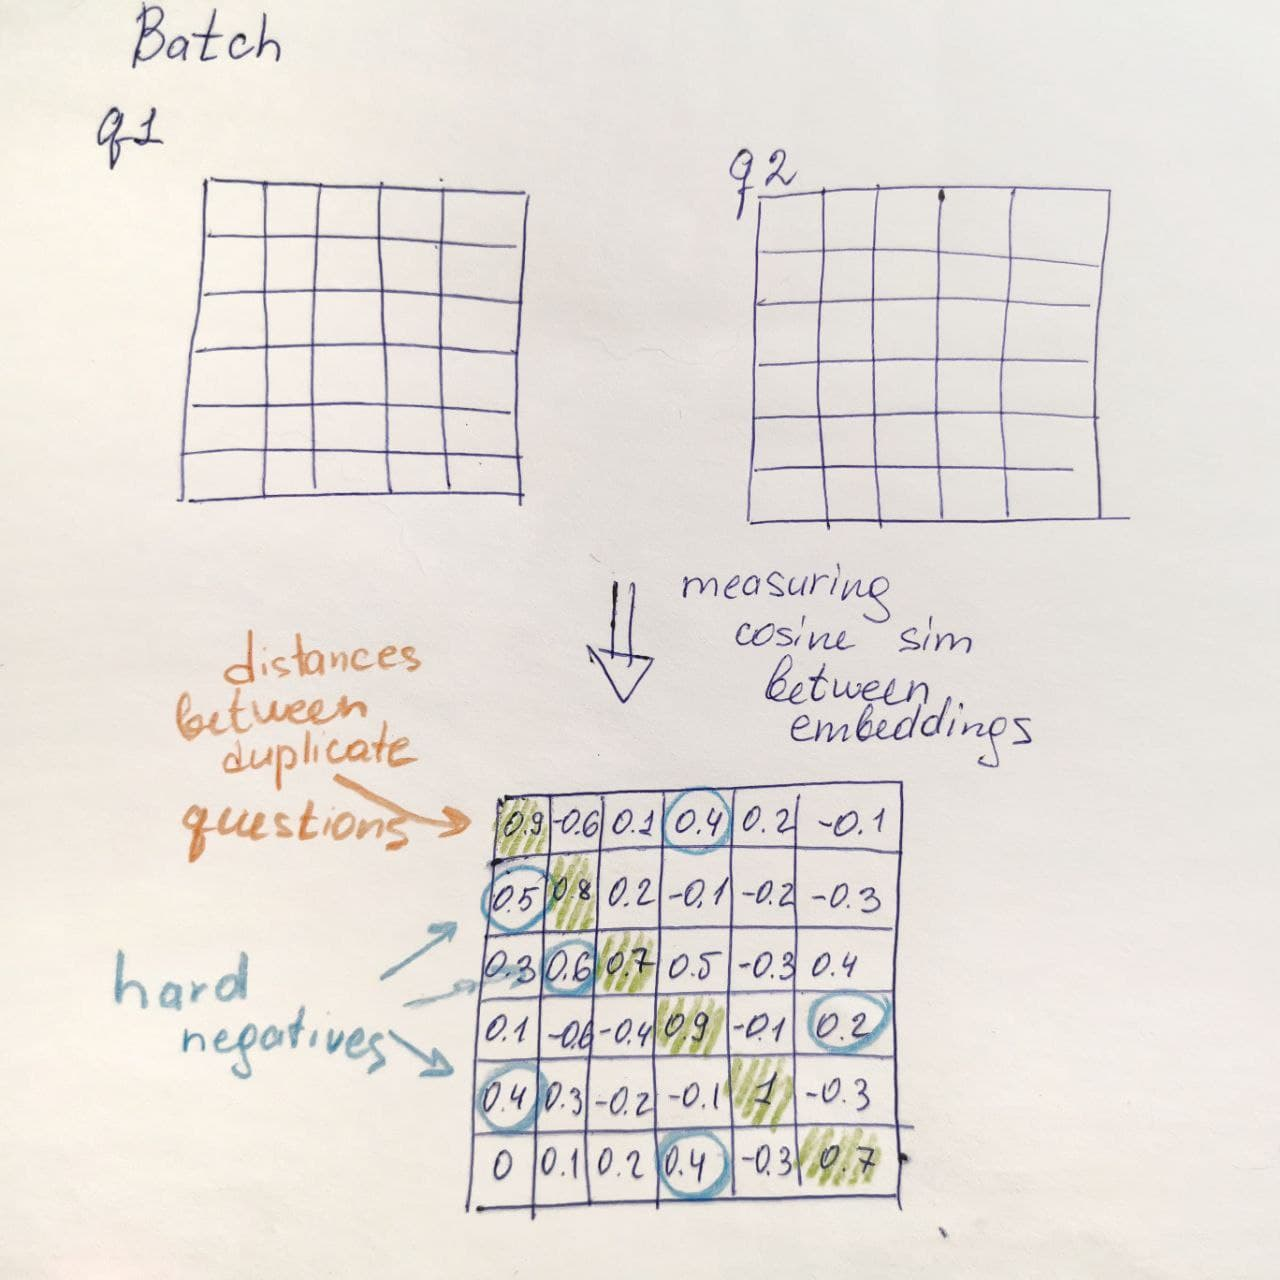

In [19]:
class TripletLoss(torch.nn.Module):
    """Custom Loss function.

    Args:
        v1 (torch.tensor): Array with dimension (batch_size, model_dimension) associated to Q1.
        v2 (torch.tensor): Array with dimension (batch_size, model_dimension) associated to Q2.
        margin (torch.tensor, optional): Desired margin. Defaults to 0.25.

    """

    # use torch functions to autograd the barward step
    def forward(self, v1, v2, margin=torch.tensor([0.25]).cuda()):
        scores = torch.mm(v1, v2.t()) # pairwise cosine sim   
        # print('scores:\n', scores)     
        batch_size = len(scores) # calculate new batch size
        # print('batch size: ', batch_size)
        positive = torch.diagonal(scores).cuda() # the positive `diagonal` entries in `scores` (duplicates)
        # print('positive:\n', positive)
        negative_without_positive = scores - (torch.eye(batch_size).cuda() * 2) # multiply `torch.eye(batch_size)` with 2.0 and subtract it out of `scores`
        # print('neg w/o pos:\n', negative_without_positive)
        closest_negative, _ = torch.max(negative_without_positive, dim=1) # take the row by row `max` of `negative_without_positive`
        # print('closest neg:\n', closest_negative)
        
        negative_zero_on_duplicate = (1.0 - torch.eye(batch_size).cuda()) * scores # subtract `torch.eye(batch_size)` out of 1.0 and do element-wise multiplication with `scores`
        # print('neg zero dupl:\n', negative_zero_on_duplicate)
        # print('neg zero dup sum:\n', torch.sum(negative_zero_on_duplicate, axis=1))
        mean_negative = torch.nn.functional.normalize(torch.sum(negative_zero_on_duplicate, axis=1), dim=0) # use `torch.sum` on `negative_zero_on_duplicate` for `axis=1` and normalize on batch_size - 1
        # print('mean_negative: ', mean_negative)        

        loss1 = torch.maximum(torch.tensor([0]).cuda(), margin - positive + closest_negative) # subtract `positive` from `margin` and add `closest_negative` and get maximum from this value and 0
        # print('loss1:\n', loss1)
        loss2 = torch.maximum(torch.tensor([0]).cuda(), margin - positive + mean_negative) # subtract `positive` from `margin` and add `mean_negative` and get maximum from this value and 0
        # print('loss2:\n', loss2)
        
        triplet_loss = torch.mean(torch.add(loss1, loss2))
        return triplet_loss

In [21]:
# v1 = torch.tensor(np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]]), requires_grad=True).cuda()
# v2 = torch.tensor(np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]]), requires_grad=True).cuda()
# loss = TripletLoss()
# res = loss(v1, v2)
# print("Triplet Loss:", res) # expecting 0.5
# res.backward()

# [7 points] **Part 4: Training the model**

To train the model we should define cost function and optimizer and the model input.

In [20]:
# you can vary the hyperparams
BATCH_SIZE = 64

train_iter = iterator(
      q1_train,
      q2_train,
      BATCH_SIZE,
)
val_iter = iterator(
      q1_val,
      q2_val,
      BATCH_SIZE,
)

In [23]:
# qq1, qq2 = train_iter[1]
# model = SiameseModel().cuda()
# output = model(torch.tensor(qq1).cuda(), torch.tensor(qq2).cuda())

In [24]:
# output

In [25]:
# TripletLoss()(*output)

In [21]:
criterion = TripletLoss()
model = SiameseModel().cuda()

# you can vary the hyperparams
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
learning_rate = 0.01
momentum = 0.9
num_epoch = 10

In [27]:
for epoch in range(num_epoch):
    losses = []
    model.train()

    for i, data in enumerate(train_iter):
        q1, q2 = data
        q1 = torch.tensor(q1).cuda()
        q2 = torch.tensor(q2).cuda()
        # calculate loss, step the optimizers, save losses

        output = model(q1, q2)        
        loss = criterion(*output)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i > 0 and i % (BATCH_SIZE * 6) == 0:
            print(f'Epoch {epoch+1}/{num_epoch} | Current Loss: {loss.item()} | Train Loss: {torch.mean(torch.tensor(losses))}')

    # eval
    model.eval()
    val_loss = []
    with torch.no_grad():
        for i, data in enumerate(val_iter):
            q1, q2 = data
            q1 = torch.tensor(q1).cuda()
            q2 = torch.tensor(q2).cuda()

            output = model(q1, q2)
            loss = criterion(*output)
            val_loss.append(loss.item())

        print(f'Epoch {epoch+1}/{num_epoch} | Val Loss: {torch.mean(torch.tensor(val_loss))}')

    # put back to train mode
    model.train()

    # print(f"Epoch {epoch}\n Current loss {torch.mean(torch.tensor(losses)):.4f}\n")
    print(f'Epoch {epoch+1}/{num_epoch} | Loss: {torch.mean(torch.tensor(losses))} | Val Loss: {torch.mean(torch.tensor(val_loss))}')

Epoch 1/10 | Current Loss: 0.25000011920928955 | Train Loss: 0.2500005066394806
Epoch 1/10 | Current Loss: 0.2500000596046448 | Train Loss: 0.2500002682209015
Epoch 1/10 | Current Loss: 0.25000011920928955 | Train Loss: 0.2500001788139343
Epoch 1/10 | Val Loss: 0.25000011920928955
Epoch 1/10 | Loss: 0.25000014901161194 | Val Loss: 0.25000011920928955
Epoch 2/10 | Current Loss: 0.25000008940696716 | Train Loss: 0.2500000298023224
Epoch 2/10 | Current Loss: 0.25000008940696716 | Train Loss: 0.25
Epoch 2/10 | Current Loss: 0.25000011920928955 | Train Loss: 0.25
Epoch 2/10 | Val Loss: 0.25000011920928955
Epoch 2/10 | Loss: 0.25 | Val Loss: 0.25000011920928955
Epoch 3/10 | Current Loss: 0.25000011920928955 | Train Loss: 0.25000008940696716
Epoch 3/10 | Current Loss: 0.25000011920928955 | Train Loss: 0.25000008940696716
Epoch 3/10 | Current Loss: 0.2500002384185791 | Train Loss: 0.2500000298023224
Epoch 3/10 | Val Loss: 0.2500000298023224
Epoch 3/10 | Loss: 0.2500000298023224 | Val Loss: 0.2

In [28]:
# save model
torch.save(model.state_dict(), 'siamese.pt')

In [22]:
model.load_state_dict(torch.load('siamese.pt'))

<All keys matched successfully>

In [23]:
model.eval()

SiameseModel(
  (emb): Embedding(76341, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (ll): Linear(in_features=256, out_features=256, bias=True)
)

In [142]:
def classify(test_q1, test_q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions.
        test_Q2 (numpy.ndarray): Array of Q2 questions.
        y (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold.
        model: The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model.
    """       
    accuracy = 0
    ### START CODE HERE (Replace 'None' with your code) ###
    # Call the data generator (built in Ex 01) with shuffle= None
    data_gen = data_generator(test_q1, test_q2, batch_size, pad=vocab['<PAD>'], shuffle=None)
    dataset = PairsDataset(*data_gen)
    for ix, i in enumerate(tqdm(dataset)):
        # Hint: use `vocab['<PAD>']` for the `pad` argument of the data generator
        q1, q2 = i
        q1 = torch.tensor(q1).cuda()
        q2 = torch.tensor(q2).cuda()
        # use batch size chuncks of actual output targets (same syntax as example above)
        y_test = y[(ix*batch_size):((ix+1)*batch_size)]
        # Call the model
        v1, v2 = model(q1, q2)
        v1 = v1.cpu().detach().numpy()
        v2 = v2.cpu().detach().numpy()
        
        # for j in range(batch_size):
        for j in range(len(v1)):
            # take dot product to compute cos similarity of each pair of entries, v1[j], v2[j]
            # don't forget to transpose the second argument
            d = np.dot(v1[j], v2[j].T)
            # is d greater than the threshold?
            res = d > threshold
            # increment accurancy if y_test is equal `res`
            accuracy += (y_test[j] == res)
        
        if ix > 0 and ix % 25 == 0:
            tqdm.write(f'Batch {ix+1}/{batch_size} | Current Accuracy: {accuracy/(ix+1)}')

    # compute accuracy using accuracy and total length of test questions
    accuracy = accuracy / len(test_q1)
    ### END CODE HERE ###
    
    return accuracy

In [143]:
accuracy = classify(q1_test, q2_test, y_test, 0.7, model, vocab, batch_size = 512) 
print("Accuracy", accuracy) # your final accuracy should be higher than 0.7

100%|██████████| 198/198 [02:20<00:00,  1.41it/s]

Accuracy 0.3692318347316764


In [134]:
data_gen = data_generator(q1_test, q2_test, 512, pad=vocab['<PAD>'], shuffle=None)
dataset = PairsDataset(*data_gen)

In [140]:
len(dataset[0][0]), len(dataset[0][1])

(512, 512)

In [141]:
[(len(i), len(j)) for i, j in dataset]

[(512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),
 (512, 512),

## Bug Fix (Identification)

In [123]:
q1_test_batch = []
q2_test_batch = []
batchsize = 512
lenq = len(q1_test)
quest_index = [*range(lenq)]

In [124]:
qq1 = q1_test[quest_index]
qq2 = q2_test[quest_index]
batchnum = ceil(lenq/batchsize)
q1_test_batch = [qq1[(i*batchsize):((i+1)*batchsize)] for i in range(batchnum)]
q2_test_batch = [qq2[(i*batchsize):((i+1)*batchsize)] for i in range(batchnum)]
type(q1_test_batch), len(q1_test_batch), type(q2_test_batch), len(q2_test_batch)

(list, 198, list, 198)

In [125]:
display(q1_test_batch[0][:5])
display(q2_test_batch[0][:5])

array([list([258, 91, 1781, 55, 3, 1172, 21, 2028, 21, 4472, 10, 222, 194, 18, 2448, 20, 573, 1785, 11]),
       list([16, 24, 274, 719, 67, 3, 5646, 84, 6383, 878, 11]),
       list([16, 17, 5127, 11]),
       list([16, 13, 18, 5856, 51, 274, 1396, 84, 18, 797, 798, 3910, 130, 6, 468, 45, 1306, 5856, 859, 51, 1757, 194, 11]),
       list([16, 194, 3, 31184, 1317, 84, 3, 3765, 8445, 10810, 11])],
      dtype=object)

array([list([16, 13, 46, 462, 84, 573, 1785, 11]),
       list([16, 24, 274, 719, 67, 3, 2709, 84, 6383, 878, 11]),
       list([16, 7305, 24, 45, 51, 112, 11]),
       list([16, 13, 18, 5856, 51, 274, 1396, 84, 18, 797, 798, 3910, 130, 6, 468, 45, 1306, 5856, 859, 51, 320, 194, 11]),
       list([23, 45, 8445, 8756, 102, 3914, 871, 1625, 11])], dtype=object)

In [126]:
print(max([len(ii) for ii in q1_train]))
print(max([len(ii) for ii in q2_train]))


81
78


In [127]:
print(q1_test_batch[0][0][:50])

[258, 91, 1781, 55, 3, 1172, 21, 2028, 21, 4472, 10, 222, 194, 18, 2448, 20, 573, 1785, 11]


In [128]:
for i in range(batchnum):    
    if i != 21:
        continue
    print('before processing')
    print('q1', q1_test_batch[i])
    print()
    print('q2', q2_test_batch[i])

    # maxlen = max(max([len(ii) for ii in qq1]), max([len(ii) for ii in qq2]))
    maxlen = max([len(ii) for ii in qq1])
    maxlen = 2**int(np.ceil(np.log2(maxlen)))
    q1_test_batch[i] = [([vocab['<PAD>']] * (maxlen-len(q))) + q[:maxlen] for q in q1_test_batch[i]]
    q2_test_batch[i] = [([vocab['<PAD>']] * (maxlen-len(q))) + q[:maxlen] for q in q2_test_batch[i]]

    print('after padding')
    print('q1', q1_test_batch[i])
    print()
    print('q2', q2_test_batch[i])

    q1_test_batch[i] = np.array(q1_test_batch[i])
    q2_test_batch[i] = np.array(q2_test_batch[i])

    print('q2 length: ', [len(ii) for ii in q2_test_batch[i]])

    print('after processed')
    print('q1', q1_test_batch[i])
    print()
    print('q2', q2_test_batch[i])

    break

before processing
q1 [list([16, 13, 46, 20, 18, 114, 0, 55, 1266, 11])
 list([36, 17, 31, 10185, 27, 33, 11]) list([16, 17, 18, 15821, 5424, 11])
 list([16, 13, 18, 577, 6, 578, 20, 743, 3542, 51, 18, 3431, 11])
 list([16, 13, 18, 114, 411, 782, 3714, 11])
 list([124, 13732, 1286, 795, 11, 258, 251, 21, 222, 13, 18, 0, 17501, 55, 3144, 11])
 list([16, 13, 46, 94, 42, 999, 50, 45, 225, 122, 54, 11])
 list([16, 9657, 6, 865, 55, 1305, 13, 3, 2635, 20, 23602, 84, 12148, 11])
 list([23, 469, 12210, 13, 37, 55, 991, 6, 1317, 819, 11])
 list([23, 24, 25, 2121, 35, 30, 27, 3266, 10, 11])
 list([36, 173, 18, 797, 798, 63, 18, 720, 721, 11])
 list([692, 25, 2550, 919, 199, 3, 916, 11])
 list([25, 8, 369, 335, 8174, 8172, 55, 378, 166, 660, 160, 91, 11])
 list([2, 6384, 878, 274, 3148, 84, 2414, 878, 11])
 list([36, 45, 8744, 1680, 1145, 396, 0, 660, 398, 55, 331, 17564, 5317, 11])
 list([23, 50, 91, 21680, 3, 1196, 11])
 list([16, 13, 18, 114, 2584, 51, 962, 1176, 136, 11])
 list([16, 505, 51, 

In [65]:
gen[0][21]

array([[    1,     1,     1, ...,    55,  1266,    11],
       [    1,     1,     1, ...,    27,    33,    11],
       [    1,     1,     1, ..., 15821,  5424,    11],
       ...,
       [    1,     1,     1, ...,    70, 12987,    11],
       [    1,     1,     1, ...,  1041,  2314,    11],
       [    1,     1,     1, ...,  3439,   229,    11]])

In [66]:
gen[1][21]

array([list([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 16, 13, 18, 114, 682, 20, 202, 55, 244, 11]),
       list([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 36, 173, 31, 3301, 27, 29, 11]),
       list([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [52]:
len(dataset[21][0])

512